In [1]:
#CT image reconstruct through the FBP algorithm
#Written by Ren-Qi Pan
import math
import os
from pydicom import dcmread
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
_pth = r'F:\EPID Images\sphere\854320165'
_pth = r'D:\CMC\pyprojects\radio_therapy\dose-3d\dataset\2024-06-08 09-51-34-MV Dosimetry-6x\854350196'
# _pth = r'F:\EPID Images\2024-05-04 17-12-18-MV Dosimetry-6x_Patient 1_Arc CW\854320170'
_files = os.listdir(_pth)

In [3]:
dcm = dcmread(os.path.join(_pth, _files[0]))
shape = dcm.Rows, dcm.Columns

In [4]:
g_angle = []
_images = np.zeros((len(_files),shape[0], shape[0]), dtype=np.uint16)
prev = np.zeros((shape[0], shape[0]), dtype=np.uint16)
curr = np.zeros((shape[0], shape[0]), dtype=np.uint16)
_raw_datas = []
for idx, _fname in enumerate(tqdm(_files)):
    raw = dcmread(os.path.join(_pth, _fname))
    curr = raw.pixel_array
    
    _m = curr - prev
    
    if np.max(_m) > 10000:
        _images[idx, :, :] = _images[idx-1, :, :]
        g_angle.append(g_angle[idx-1])
    else:
        _images[idx, :, :] = curr - prev
        prev = curr
        g_angle.append(raw.GantryAngle)
        
    prev = curr


  0%|          | 0/398 [00:00<?, ?it/s]

 57%|█████▋    | 225/398 [00:05<00:03, 43.66it/s]

In [ ]:
g_angle = np.array(g_angle)
sorted_inx = np.argsort(g_angle)

sorted_images = np.zeros((len(_files),shape[0], shape[0]), dtype=np.uint16)

for idx, val in enumerate(tqdm(sorted_inx)):
    sorted_images[idx, :, :] = _images[val, :, :]

100%|██████████| 398/398 [00:00<00:00, 1266.61it/s]


In [ ]:
g_angle2 = g_angle[sorted_inx]
_images = []

In [ ]:
#define the filter function: Ram-Lak (R-L) filter and the Shepp-Logan(S-L) filter
#N:number of detector cells
#d: step width of detector cells
PI=math.pi

def filter_SL(N,d):
    fh_SL=np.zeros(N)
    for k1 in range(0,N,1):
        fh_SL[k1]=-2.0/(PI*PI*d*d*(4*(k1-N/2.0)**2-1))
    return fh_SL

def nearestPowerOf2(N):
    # Calculate log2 of N
    a = int(math.log2(N))
    if 2**a == N:
        return N
    return 2**(a + 1)

In [ ]:
from scipy.fft import fft, ifft

def Fun_Weigth_Projection(projection_beta,SOD,delta_dd):
    Nrows,Ncolumns=projection_beta.shape
    dd_column=delta_dd*np.arange(-Ncolumns/2+0.5,(Ncolumns/2+1)-0.5,1.0)#coordinate of detector cell in horizontal 
    dd_row=delta_dd*np.arange(-Nrows/2+0.5,(Nrows/2+1)-0.5,1.0)#coordinate of detector cell in vertical
    dd_row2D,dd_column2D=np.meshgrid(dd_row,dd_column,indexing='ij')
    weighted_projection=projection_beta*SOD/np.sqrt(SOD*SOD+np.power(dd_row2D,2.0)+np.power(dd_column2D,2.0))
    return weighted_projection

def optimize_convolution(weighted_projection, fh_RL):
    Nrows, Ncolumns = weighted_projection.shape
    Nfft = nearestPowerOf2(2 * Ncolumns - 1)
    fh_RL_padded = np.zeros(Nfft)
    fh_RL_padded[:len(fh_RL)] = fh_RL / 2.0  # Scale and pad filter response
    
    fh_RL_fft = fft(fh_RL_padded)  # FFT of the filter response
    
    # Zero pad the input projection for FFT
    projection_padded = np.zeros((Nrows, Nfft))
    projection_padded[:, :Ncolumns] = weighted_projection

    # Perform FFT on each row of the projection
    projection_fft = fft(projection_padded, axis=1)
    
    # Element-wise multiplication in the frequency domain
    convoluted_freq = projection_fft * fh_RL_fft
    
    # Perform the inverse FFT to get back to the time domain
    convoluted_time = ifft(convoluted_freq, axis=1).real
    
    # Slice to obtain the result with the correct dimensions
    filtered_projection = convoluted_time[:, :Ncolumns]
    
    return filtered_projection


def Fun_Filter_Projection(weighted_projection,fh_RL):
    Nrows,Ncolumns=weighted_projection.shape
    Nfft=nearestPowerOf2(2*Ncolumns-1)
    filtered_projection=np.zeros((Nrows,Ncolumns))
    for row in range(Nrows):
        projection_row=weighted_projection[row,:]
        zeros_pad=np.zeros(Nfft-Ncolumns)
        projection_row=np.concatenate((projection_row,zeros_pad))
        convoluted_time=np.convolve(projection_row,fh_RL/2.0,mode='same')
        convoluted_time=convoluted_time[:Ncolumns]
        filtered_projection[row,:]=convoluted_time
    return filtered_projection

def Fun_BackProjection(filtered_projection,SOD,beta_num,beta_m,delta_dd,Nimage):
    Nrows,Ncolumns=filtered_projection.shape
    MX, MZ=Nimage,int(Nimage*Nrows/Ncolumns)
    #roi[0], roi[1]: the min and max of x-axis and y-axis
    #roi[2],roi[3]: the min and max of z-axis
    
    roi=delta_dd*np.array([-Ncolumns/2.0+0.5,Ncolumns/2.0-0.5,-Nrows/2.0+0.5,Nrows/2.0-0.5])
    hx=(roi[1]-roi[0])/(MX-1) #interval of x-axis and y-axis
    xrange=roi[0]+hx*np.arange(0,MX) #coordinate vector of x-axis and y-axis 
    hy=(roi[3]-roi[2])/(MZ-1) #interval of z-axis
    yrange=roi[2]+hy*np.arange(0,MZ) #coordinate vector of z-axis 
    XX,YY,ZZ=np.meshgrid(xrange,xrange,yrange,indexing='ij')
    temp_rec=np.zeros((MX,MX,MZ)) #store back projection contribution
    U=(SOD+XX*np.sin(beta_m)-YY*np.cos(beta_m))/SOD
    a=(XX*np.cos(beta_m)+YY*np.sin(beta_m))/U
    xx=np.int32(np.floor(a/delta_dd)) #beam numbering,strart from -Ncolumns/2
    u1=a/delta_dd-xx  #the decimal part of a
    b=ZZ/U
    yy=np.int32(np.floor(b/delta_dd)) #beam numbering,strart from -Nrows/2
    u2=b/delta_dd-yy #the decimal part of b
    xx=xx+int(Ncolumns/2) #numbering from 0
    yy=yy+int(Nrows/2) #numbering from 0

    mask=np.where((xx >=0) & (xx< Ncolumns-1) & (yy >=0) & (yy<Nrows-1))
    xx=xx[mask]
    yy=yy[mask]
    u1=u1[mask]
    u2=u2[mask]
    # print(mask)
    temp=(1-u1)*(1-u2)*filtered_projection[yy,xx]+(1-u1)*u2*filtered_projection[yy+1,xx]+\
                 (1-u2)*u1*filtered_projection[yy,xx+1]+u1*u2*filtered_projection[yy+1,xx+1]
    temp_rec[mask]=temp_rec[mask]+temp/(np.power(U[mask],2))*2*PI/beta_num
    print('backprojection, beta: ',round(beta_m*180/PI,1))
    return temp_rec


In [ ]:
def ConeBeam_FDK_Backprojection(projection,fh_RL,beta,SOD,Nimage,delta_dd):
    # projection: projection data in 3D, (angle,row, colums)
    # fh_RL: R-L filter function
    # beta: rotate angles in degrees
    # SOD: source to rotation center distance in mm unit
    # delta_dd: interval of the virtual detector cell
    Ncolumns=projection.shape[2]
    Nrows=projection.shape[1]
    rec_image=np.zeros((Nimage,Nimage,int(Nimage*Nrows/Ncolumns)))
    beta_num=len(beta) #number of angles
    beta=beta*PI/180.0 # view angle in radian
    for m in range(0, beta_num,1):
        projection_beta=projection[m,:,:] #projection matrix at the beta angle
        weighted_projection=Fun_Weigth_Projection(projection_beta,SOD,delta_dd)
        filtered_projection=optimize_convolution(weighted_projection,fh_RL)
        rec_image=rec_image+Fun_BackProjection(weighted_projection,SOD,beta_num,beta[m],delta_dd,Nimage)
        # break
    return rec_image

In [ ]:
sorted_images.shape

(398, 1190, 1190)

In [ ]:
Ncolumns = sorted_images.shape[2]

In [ ]:
SID = dcm.RTImageSID
SAD = dcm.RadiationMachineSAD

In [ ]:
Nimage=100 #size of image
beta=g_angle2 #rotate(view) angles
SOD=SAD#source to origin distance, in unit mm
SDD=SID #source to center of detector, in unit mm
width=0.172 #size of detector cell, in unit mm
delta_dd=width*SOD/SDD #interval of the virtual detector cell
Nfft=nearestPowerOf2(2*Ncolumns-1) #number of points for FFT
fh_RL=filter_SL(Nfft,delta_dd)  #get the filter kernel function
#reconstruct the scanned object through the FBP algorithm
rec_image=ConeBeam_FDK_Backprojection(sorted_images,fh_RL,beta,SOD,Nimage,delta_dd)

backprojection, beta:  0.4
backprojection, beta:  1.3
backprojection, beta:  2.3
backprojection, beta:  3.2
backprojection, beta:  4.1
backprojection, beta:  5.0
backprojection, beta:  5.9
backprojection, beta:  6.8
backprojection, beta:  7.7
backprojection, beta:  8.6
backprojection, beta:  9.5
backprojection, beta:  10.4
backprojection, beta:  11.3
backprojection, beta:  12.3
backprojection, beta:  13.2
backprojection, beta:  14.1
backprojection, beta:  15.0
backprojection, beta:  15.9
backprojection, beta:  16.8
backprojection, beta:  17.7
backprojection, beta:  18.6
backprojection, beta:  19.5
backprojection, beta:  20.4
backprojection, beta:  21.4
backprojection, beta:  22.3
backprojection, beta:  23.2
backprojection, beta:  24.1
backprojection, beta:  25.0
backprojection, beta:  25.9
backprojection, beta:  26.8
backprojection, beta:  27.7
backprojection, beta:  28.6
backprojection, beta:  29.5
backprojection, beta:  30.4
backprojection, beta:  31.3
backprojection, beta:  32.3
bac

In [ ]:
np.pad(rec_image[X_c,:,:].T, (0, 0), 'constant', constant_values=(0, 0)).shape

(100, 100)

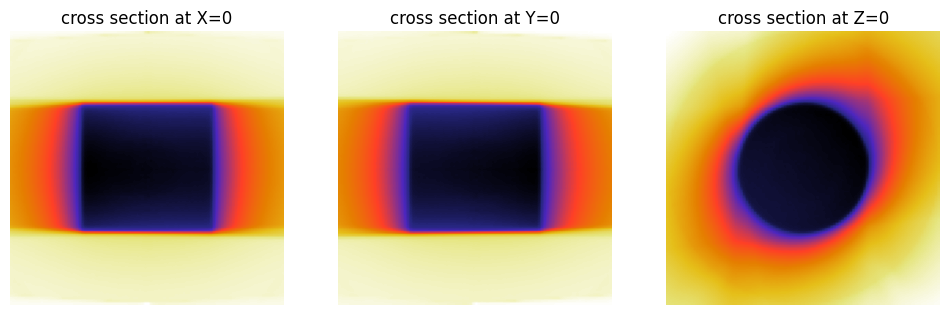

In [ ]:
NimageZ=Nimage*sorted_images.shape[0]/sorted_images.shape[0]
Z_c=int(NimageZ/2.0)
X_c=int(Nimage/2.0)
Y_c=int(Nimage/2.0)
figure, axis=plt.subplots(1, 3,figsize=(12,12))
axis[0].imshow(rec_image[X_c,:,:].T, cmap='CMRmap_r')
axis[0].set_title('cross section at X=0')
axis[0].axis('off')
axis[1].imshow(rec_image[:,Y_c,:].T, cmap='CMRmap_r')
axis[1].set_title('cross section at Y=0')
axis[1].axis('off')
axis[2].imshow(rec_image[:,:,Z_c].T, cmap='CMRmap_r')
axis[2].set_title('cross section at Z=0')
axis[2].axis('off')
# plt.savefig(directory+"rec_image.pdf",format='pdf',dpi=250)
plt.show()

In [ ]:
_TPS_pth = r"D:\CMC\pyprojects\radio_therapy\dose-3d\dataset\3DDose\RD.23022024.12 x 12.dcm"

tps_dcm = dcmread(_TPS_pth)
tps_image = tps_dcm.pixel_array


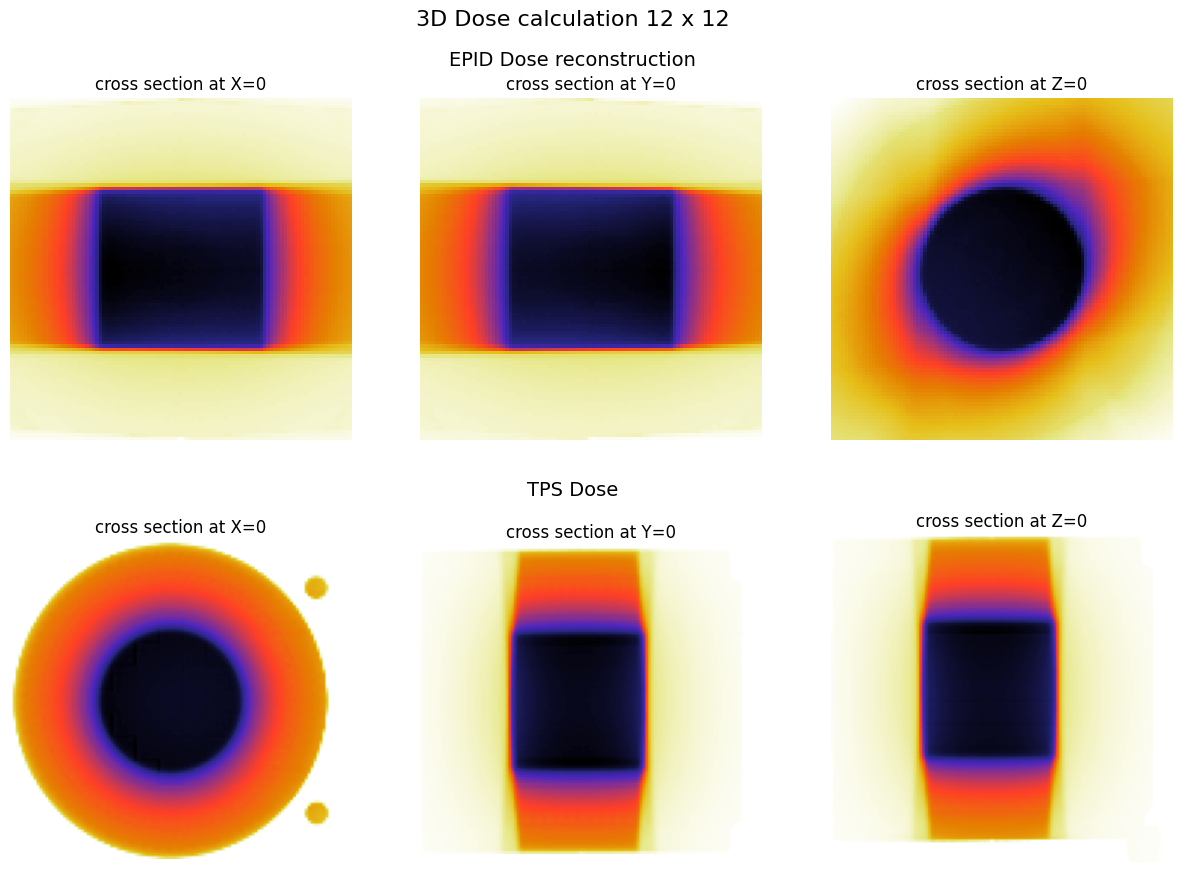

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# First row
fig.suptitle('3D Dose calculation 12 x 12', fontsize=16)
fig.subplots_adjust(top=0.9)  # Adjust the top to make room for the main title

# First row
axs[0,0].imshow(rec_image[X_c,:,:].T, cmap='CMRmap_r')
axs[0,0].set_title('cross section at X=0')
axs[0,0].axis('off')
axs[0,1].imshow(rec_image[:,Y_c,:].T, cmap='CMRmap_r')
axs[0,1].set_title('cross section at Y=0')
axs[0,1].axis('off')
axs[0,2].imshow(rec_image[:,:,Z_c].T, cmap='CMRmap_r')
axs[0,2].set_title('cross section at Z=0')
axs[0,2].axis('off')
fig.text(0.5, 0.93, 'EPID Dose reconstruction', ha='center', va='center', fontsize=14)

# Second row
axs[1, 0].imshow(tps_image[X_c,:,:].T, cmap='CMRmap_r')
axs[1, 0].set_title('cross section at X=0')
axs[1, 0].axis('off')
axs[1, 1].imshow(tps_image[:,Y_c,:].T, cmap='CMRmap_r')
axs[1, 1].set_title('cross section at Y=0')
axs[1, 1].axis('off')
axs[1, 2].imshow(tps_image[:,:,Z_c].T, cmap='CMRmap_r')
axs[1, 2].set_title('cross section at Z=0')
axs[1, 2].axis('off')
fig.text(0.5, 0.5, 'TPS Dose', ha='center', va='center', fontsize=14)

plt.show()

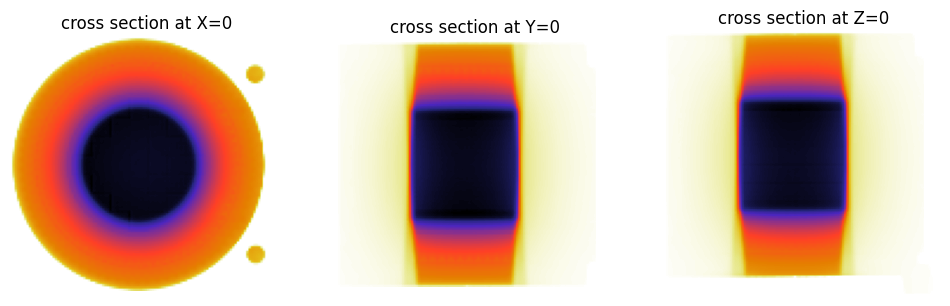

In [ ]:
_TPS_pth = r"D:\CMC\pyprojects\radio_therapy\dose-3d\dataset\3DDose\RD.23022024.12 x 12.dcm"

tps_dcm = dcmread(_TPS_pth)
tps_image = tps_dcm.pixel_array

figure, axis=plt.subplots(1, 3,figsize=(12,12))
axis[0].imshow(tps_image[X_c,:,:].T, cmap='CMRmap_r')
axis[0].set_title('cross section at X=0')
axis[0].axis('off')
axis[1].imshow(tps_image[:,Y_c,:].T, cmap='CMRmap_r')
axis[1].set_title('cross section at Y=0')
axis[1].axis('off')
axis[2].imshow(tps_image[:,:,Z_c].T, cmap='CMRmap_r')
axis[2].set_title('cross section at Z=0')
axis[2].axis('off')
# plt.savefig(directory+"rec_image.pdf",format='pdf',dpi=250)
plt.show()

In [ ]:
rec_image2=np.int32(rec_image*(np.max(tps_image)/np.max(rec_image)))

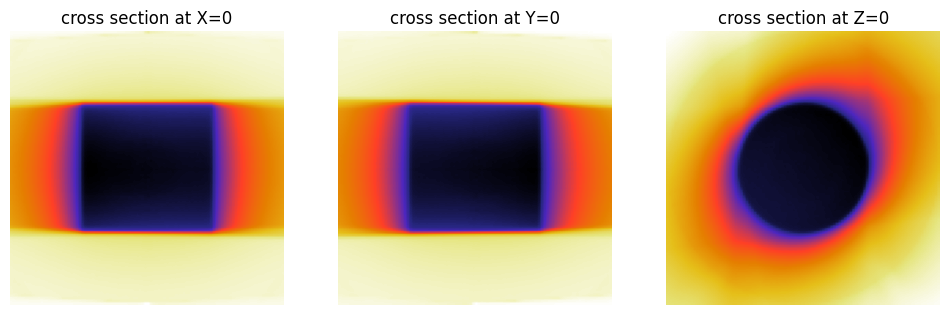

In [ ]:
NimageZ=Nimage*sorted_images.shape[0]/sorted_images.shape[0]
Z_c=int(NimageZ/2.0)
X_c=int(Nimage/2.0)
Y_c=int(Nimage/2.0)
figure, axis=plt.subplots(1, 3,figsize=(12,12))
axis[0].imshow(rec_image2[X_c,:,:].T, cmap='CMRmap_r')
axis[0].set_title('cross section at X=0')
axis[0].axis('off')
axis[1].imshow(rec_image2[:,Y_c,:].T, cmap='CMRmap_r')
axis[1].set_title('cross section at Y=0')
axis[1].axis('off')
axis[2].imshow(rec_image2[:,:,Z_c].T, cmap='CMRmap_r')
axis[2].set_title('cross section at Z=0')
axis[2].axis('off')
# plt.savefig(directory+"rec_image.pdf",format='pdf',dpi=250)
plt.show()

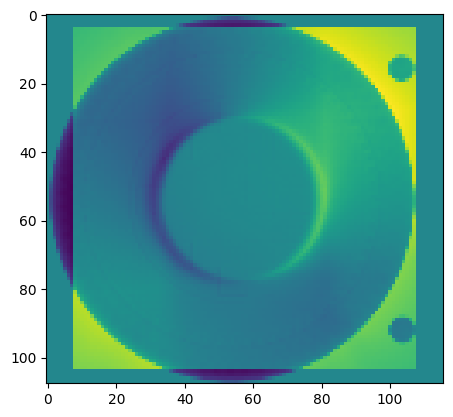

In [ ]:
image1 = rec_image2[:,:,Z_c].T
image2 = tps_image[X_c,:,:].T

image1_shape = image1.shape
image2_shape = image2.shape

pad_top = (image2_shape[0] - image1_shape[0]) // 2
pad_bottom = image2_shape[0] - image1_shape[0] - pad_top
pad_left = (image2_shape[1] - image1_shape[1]) // 2
pad_right = image2_shape[1] - image1_shape[1] - pad_left

# Pad image1 with zeros
image1_padded = np.pad(image1, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)

plt.imshow()


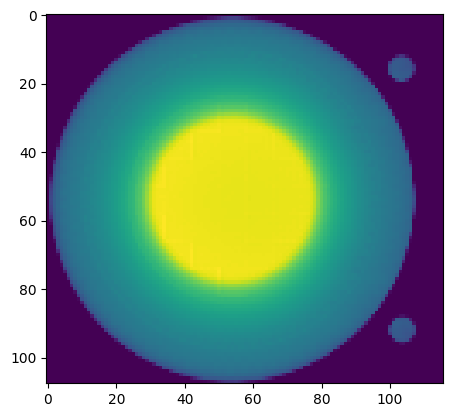

In [ ]:
plt.imshow(image2)

In [ ]:
tps_image[X_c,:,:].T.shape

(108, 116)

In [ ]:
np.max(tps_dcm.pixel_array)

1038022

In [ ]:
tps_dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 188
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: RT Dose Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.246.352.71.7.941004452793.2778321.20240601124146
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.246.352.70.2.1.160.3
(0002, 0013) Implementation Version Name         SH: 'DCIE 16.1'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0012) Instance Creation Date              DA: '20240618'
(0008, 0013) Instance Creation Time              TM: '152625'
(0008, 0016) SOP Class UID                       UI: RT Dose Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.246.352.71.7.941004452793.2778321.20240601124146
(0008, 0020) S

In [ ]:
np.max(tps_dcm.pixel_array)

1038022

: 